# Predicting hotel booking cancellations in Python

In this workspace, we will build a machine learning model to predict whether or not a customer cancelled a hotel booking.

We will use a dataset on hotel bookings from the article ["Hotel booking demand datasets"](https://www.sciencedirect.com/science/article/pii/S2352340918315191), published in the Elsevier journal, [Data in Brief](https://www.sciencedirect.com/journal/data-in-brief). The abstract of the article states 

> This data article describes two datasets with hotel demand data. One of the hotels (H1) is a resort hotel and the other is a city hotel (H2). Both datasets share the same structure, with 31 variables describing the 40,060 observations of H1 and 79,330 observations of H2. Each observation represents a hotel booking. Both datasets comprehend bookings due to arrive between the 1st of July of 2015 and the 31st of August 2017, including bookings that effectively arrived and bookings that were canceled. 

For convenience, the two datasets have been combined into a single csv file `data/hotel_bookings.csv`. Let us start by importing all the functions needed to import, visualize and model the data.

In [25]:
# Data imports
import pandas as pd
import numpy as np

# Visualization imports
import plotly.express as px

# ML Imports and configuration
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import set_config
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
set_config(display="diagram")

## 1. Import the data

The first step in any machine learning workflow is to get the data and explore it.

In [26]:
hotel_bookings = pd.read_csv('data/hotel_bookings.csv')
hotel_bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


As a quick exploration, let us look at the number of bookings by month.

In [31]:
bookings_by_month = hotel_bookings.groupby('arrival_date_month', as_index=False)[['hotel']].count().rename(columns={"hotel": "nb_bookings"})
                                                                                                                    
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'] 
fig = px.bar(
    bookings_by_month, 
    x='arrival_date_month', 
    y='nb_bookings', 
    title=f'Bookings per Month', 
    category_orders={"arrival_date_month": months})

fig.show(config={"displayModeBar": False})

Our objective is to build a classification model - or classifier - that predicts whether or not a user cancelled a hotel booking.

## 1. Split the data into training and test sets.

Let us start by defining a split to divide the data into training and test sets. The basic idea is to train the model on a portion of the data and test its performance on the other portion that has not been seen by the model. This is done in order to prevent __overfitting__.

In [47]:
# List all numberical features
features_num = [
    "lead_time", "arrival_date_week_number", "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies", "is_repeated_guest" ,
    "previous_cancellations", "previous_bookings_not_canceled", "agent", "company", 
    "required_car_parking_spaces", "total_of_special_requests", "adr"
]

# List all categorical features
features_cat = [
    "hotel", "arrival_date_month", "meal", "market_segment", "distribution_channel", 
    "reserved_room_type", "deposit_type", "customer_type"
]

features = features_num + features_cat

X = hotel_bookings[features]
y = hotel_bookings['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, random_state = 420)

## 2. Preprocess the data

The next step is to set up a pipeline to preprocess the features. We will impute all missing values with a constant, and one-hot encode all categorical features.

In [53]:
transformer_num = SimpleImputer(strategy='constant')

transformer_cat = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy='constant', fill_value='unknown')),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", transformer_num, features_num),
    ("cat", transformer_cat, features_cat)
])

preprocessor

ColumnTransformer(transformers=[('num', SimpleImputer(strategy='constant'),
                                 ['lead_time', 'arrival_date_week_number',
                                  'arrival_date_day_of_month',
                                  'stays_in_weekend_nights',
                                  'stays_in_week_nights', 'adults', 'children',
                                  'babies', 'is_repeated_guest',
                                  'previous_cancellations',
                                  'previous_bookings_not_canceled', 'agent',
                                  'company', 'required_car_parking_spaces',
                                  'total_of_special_requests', 'adr']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['hotel', 'arrival_date_month', 'meal',
                                  'market_segment', 'distribution_channel',
                                  'reserved_room_type', 'deposit_type',
                                  'customer_type'])])

## 4. Fit the models and evaluate performance

Next, we extend the pipeline to fit a Decision Tree model on the training data.

In [54]:
# Compose data preprocessing and model into a single pipeline
steps = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(random_state=123))
])
steps.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['lead_time',
                                                   'arrival_date_week_number',
                                                   'arrival_date_day_of_month',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'adults', 'children',
                                                   'babies',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'agent', 'company',
                                                   'r...
                                                   'total_of_special_requests',
                                                   'adr']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hotel',
                                                   'arrival_date_month', 'meal',
                                                   'market_segment',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'deposit_type',
                                                   'customer_type'])])),
                ('model', DecisionTreeClassifier(random_state=123))])

To see how well our model performed, we'll calculate and visualize a confusion matrix, and calculate the accuracy of the model

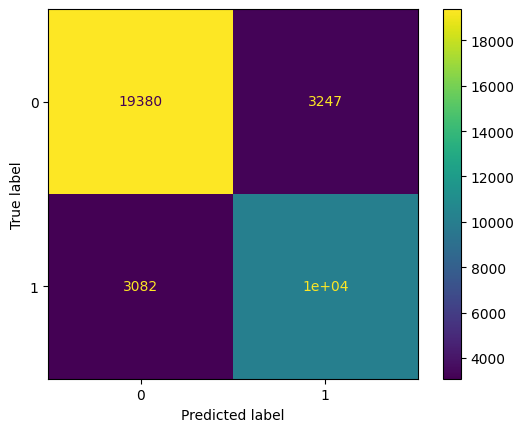

In [58]:
plot_confusion_matrix(steps, X_test, y_test)

In [62]:
y_pred = steps.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Accuracy:',acc)

Accuracy: 0.8232962001284306


### Manuall calculation of conf.matrix and accuracy

In [65]:
conf = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n',conf)

Confusion Matrix:
 [[19380  3247]
 [ 3082 10108]]


In [67]:
accuracy_score = (conf[0][0]+conf[1][1])/np.sum(conf)

print('Accuracy Score:', accuracy_score)

Accuracy Score: 0.8232962001284306


## The end!

With this trained pipeline, we can now predict whether or not a new, previously unsoon booking will be cancelled with an accuracy of roughly 80%. This can be useful in planning room availability or identifying which guests are at risk of cancelling their booking to take corrective action.

## Reference: Data Dictionary

|variable                        |class       |description                                                                                      |
|:-------------------------------|:-----------|:------------------------------------------------------------------------------------------------|
|adr                             |numeric     |Average daily rate                                                                               |
|adults                          |integer     |Number of adults                                                                                 |
|agent                           |categorical |The id of the travel agency                                                                      |
|arrival_date_day_of_month       |integer     |Day of the month of the arrival date                                                             |
|arrival_date_month              |categorical |Month of arrival date with 12 categories: “January” to “December”                                |
|arrival_date_week_number        |integer     |Week number of the arrival date                                                                  |
|arrival_date_year               |integer     |Year of arrival date                                                                             |
|assigned_room_type              |categorical |The code for type of room assigned                                                               |
|babies                          |integer     |Number of babies                                                                                 |
|booking_changes                 |integer     |The number of changes made to the booking                                                        |
|children                        |integer     |Number of children                                                                               |
|company                         |categorical |The id of the company making the booking                                                         |
|country                         |categorical |The country of originin ISO 3155-3:2013 format                                                   |
|customer_type                   |categorical |The type of booking: Contract / Group / Transient / Transient-Party                              |
|days_in_waiting_list            |integer     |The number of days the booking was in the waiting list                                           |
|deposit_type                    |categorical |The type of deposit: No Deposit / Non Refund / Refundable                                        |
|distribution_channel            |categorical |The booking distribution channel: TA / TO etc.                                                   |
|is_cancelled                    |categorical |A boolean indicating if the booking was cancelled (1) or not (0)                                 |
|is_repeated_guest               |categorical |A boolean indicating if it was a repeated guest (1) or not (0)                                   |
|lead_time                       |integer     |The number of days between the booking date and arrival date                                     |
|market_segment                  |categorical |A designation for the market segment: TA. TO                                                     |
|meal                            |categorical |The type of meal booked: Bed & Breakfast (BB), Half Board (HB), and Full Board (FB)              |
|previous_bookings_not_cancelled |integer     |The number of previous bookings not cancelled by the customer prior to the current booking       |
|previous_cancellations          |integer     |The number of previous bookings that were cancelled by the customer prior to the current booking |
|required_car_parking_spaces     |integer     |The number of car parking spaces required by the customer                                        |
|reservation_status              |categorical |The last status of the reservation: Canceled / Check-Out / No-Show                               |
|reservation_status_date         |date        |The date at which the last status was set.                                                       |
|reserved_room_type              |categorical |The code of room type reserved.                                                                  |
|stays_in_weekend_nights         |integer     |The number of weekend nights stayed or booked to stay                                            |
|stays_in_week_nights            |integer     |The number of week nights stayed or booked to stay                                               |
|total_of_special_requests       |integer     |The number of special requests made by the customer                                              |